- https://www.kaggle.com/haqishen/augmentation-methods-for-audio
- https://www.kaggle.com/CVxTz/audio-data-augmentation

In [1]:
import os
import sys
from glob import glob

import numpy as np
from librosa.feature import melspectrogram
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import cv2 # !pip install opencv-python

from config import TRAIN_PATH, TEST_PATH, OUTPUT_PATH
from vis_utils import show_spectrogram, show_wave
from preprocess_utils import list_wavs_fname, chop_audio

EPS = 1e-8

In [2]:
# mel = librosa.feature.melspectrogram(wav, sr=sr, n_mels=200, hop_length=60, fmin=20, fmax=4000)
# melgram = librosa.logamplitude(mel, ref_power=1.0)

In [3]:
# sample_rate=16000
# figsize=(20, 4)
# fig = plt.figure(figsize=figsize)
# print(melgram.shape)
# plt.imshow(melgram, aspect='auto', origin='lower')
# plt.title('Spectrogram')
# plt.ylabel('Freqs in Hz')
# plt.xlabel('Seconds')
# plt.show()

In [4]:
# show_spectrogram(wav)

# Practice

In [5]:
file_path = os.path.join(TRAIN_PATH, 'yes/0a7c2a8d_nohash_0.wav')

In [6]:
wav, sr = librosa.load(file_path, sr=None)

In [7]:
# Samples
wav

array([ 0.00042725, -0.00021362, -0.00042725, ...,  0.00057983,
        0.00061035,  0.00082397], dtype=float32)

In [8]:
sr # Sampling rate

16000

In [9]:
print(wav.shape, wav.max(), wav.min())

(16000,) 0.28720093 -0.19668579


In [10]:
# melgram = librosa.logamplitude(librosa.feature.melspectrogram(wav, sr=sr, n_mels=96),ref_power=1.0)[np.newaxis,np.newaxis,:,:]
# melgram

In [11]:
def show_wave(samples, sample_rate=16000, figsize=(20, 4)):
    fig = plt.figure(figsize=figsize)
    plt.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
    plt.title('Raw wave')
    plt.ylabel('Amplitude')
    plt.show()

def log_specgram(wav, eps=1e-8):
    '''
    로그 스펙트로그램 변환
    '''
    D = librosa.stft(wav, n_fft=240, hop_length=60, win_length=240, window='hamming')
    spect, phase = librosa.magphase(D)
    return np.log(spect + eps)

def show_spectrogram(wav, sample_rate=16000, figsize=(20, 4)):
    spect = log_specgram(wav)
    print(spect.shape)
    fig = plt.figure(figsize=figsize)
    plt.imshow(spect, aspect='auto', origin='lower')
    plt.title('Spectrogram')
    plt.ylabel('Freqs in Hz')
    plt.xlabel('Seconds')
    plt.show()

In [12]:
ipd.Audio(wav, rate=sr)

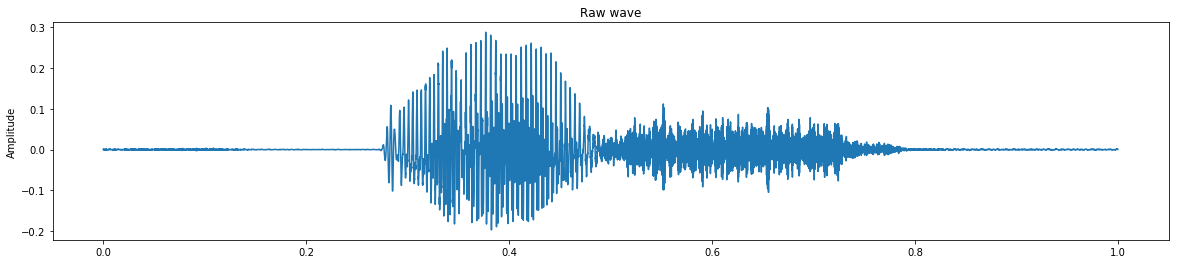

In [13]:
show_wave(wav)

(121, 267)


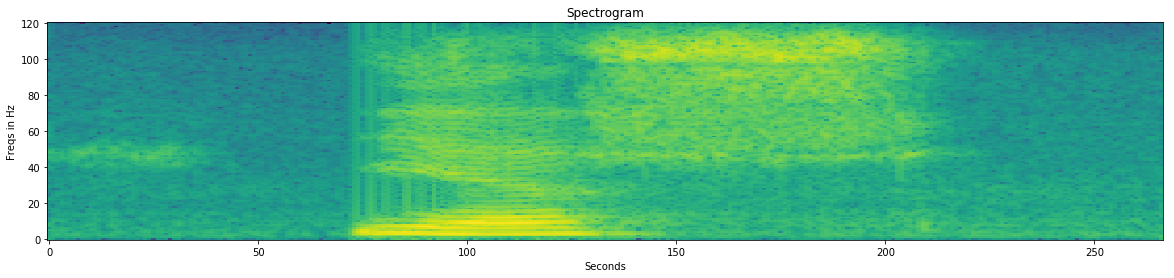

In [14]:
show_spectrogram(wav)

# Augmentation

## 1. Time shifting

In [15]:
start_ = int(np.random.uniform(-4800,4800))
print('time shift: ',start_)
if start_ >= 0:
    wav_time_shift = np.r_[wav[start_:], np.random.uniform(-0.001,0.001, start_)]
else:
    wav_time_shift = np.r_[np.random.uniform(-0.001,0.001, -start_), wav[:start_]]
ipd.Audio(wav_time_shift, rate=sr)

time shift:  -3182


(121, 267)


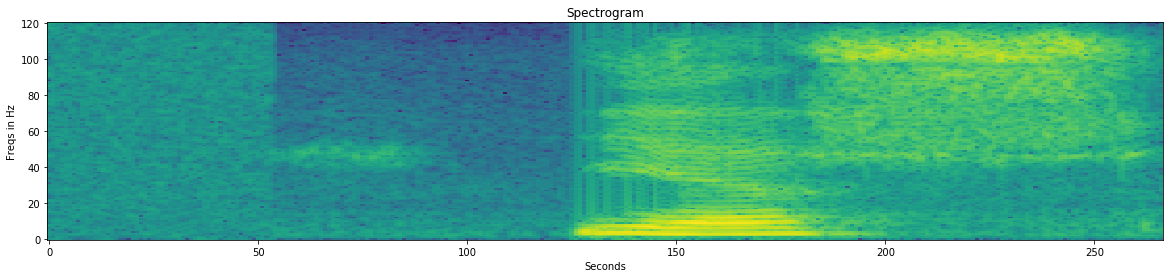

In [16]:
show_spectrogram(wav_time_shift)

## 2. Speed tuning

In [18]:
speed_rate = np.random.uniform(0.7,1.3)
wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()
print('speed rate: %.3f' % speed_rate, '(lower is faster)')
if len(wav_speed_tune) < 16000:
    pad_len = 16000 - len(wav_speed_tune)
    wav_speed_tune = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),
                           wav_speed_tune,
                           np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
else: 
    cut_len = len(wav_speed_tune) - 16000
    wav_speed_tune = wav_speed_tune[int(cut_len/2):int(cut_len/2)+16000]
print('wav length: ', wav_speed_tune.shape[0])
ipd.Audio(wav_speed_tune, rate=sr)

speed rate: 1.231 (lower is faster)
wav length:  16000


In [19]:
speed_rate = 2.0
wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()

In [20]:
len(wav), len(wav_speed_tune)

(16000, 32000)

In [21]:
cut_len = len(wav_speed_tune) - 16000

In [22]:
wav_speed_tune[int(cut_len/2):int(cut_len/2)+16000]

array([ 3.0517578e-05,  3.0517578e-05,  3.0517578e-05, ...,
       -1.5487671e-03,  5.0582886e-03,  4.4403076e-03], dtype=float32)

(121, 534)


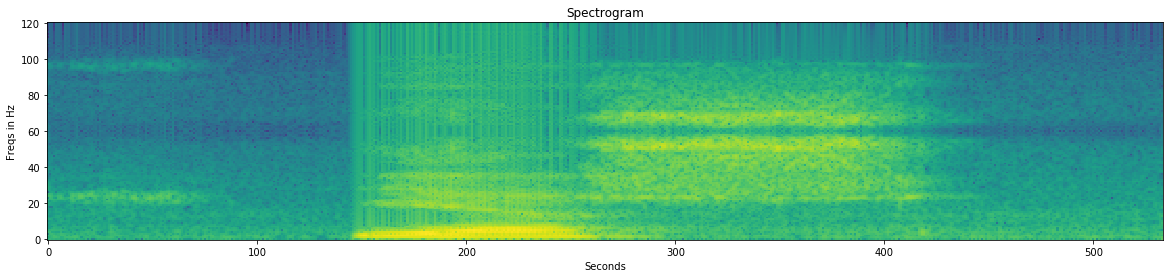

In [23]:
show_spectrogram(wav_speed_tune)

# 3 & 4. Mix background noise & volume tuning

In [17]:
# # bg_files = os.listdir('../input/train/audio/_background_noise_/')
# # bg_files.remove('README.md')
# chosen_bg_file = bg_files[np.random.randint(6)]
# bg, sr = librosa.load('../input/train/audio/_background_noise_/'+chosen_bg_file, sr=None)
# print(chosen_bg_file,'|', bg.shape[0], bg.max(), bg.min())
# ipd.Audio(bg, rate=sr) # !! be prepared when playing the noise, bacause it's so ANNOYING !!

# Chopping _background_noise_ 

In [24]:
labels, fnames = list_wavs_fname(TRAIN_PATH)

../../input/train/audio/


In [24]:
%%time
## 각 폴더에 'chopped_' 이 앞에 붙은 1분씩 쪼개진 _background_noise_ 파일 생성.
for label, fname in zip(labels, fnames):
    if label == '_background_noise_':
        wav, sr = librosa.load(os.path.join(TRAIN_PATH, label, fname), sr=None)
        for i, chopped_wav in enumerate(chop_audio(wav, L=16000, num=250, speed_tuning=True, tuning_proba=0.7)):
            n_fname = 'chopped_{}_{}'.format(i, fname)
            librosa.output.write_wav(os.path.join(TRAIN_PATH, label, n_fname), chopped_wav, sr)

CPU times: user 37.8 s, sys: 208 ms, total: 38 s
Wall time: 11.1 s


In [23]:
# # 다시 원래대로 롤백하려면... ('nm_' 이 앞에 붙은 파일 제거)
# fpaths = glob(os.path.join(TRAIN_PATH, r'*/chopped_*' + 'wav'))
# print(len(fpaths))
# for fpath in fpaths:
#     os.remove(fpath)